# Import and Data Load


In [158]:
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


from sklearn.metrics import accuracy_score


from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split


import time
import warnings
warnings.filterwarnings('ignore')


In [159]:
train = pd.read_csv("train.csv")

# Data Description

- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### Preview

In [160]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Clean the Data

In [161]:
print(train.nunique())

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64


- `PassengerId` - Unique
- `HomePlanet` - 3 classes
- `CryoSleep` - Bool
- `Cabin` - Better described as port and side classes
- `Destination` - 3 classes
- `Age` - Float
- `VIP` - Bool
- `RoomService`, Float
- `Name` - Unique
- `Transported` - Bool

### Tasks
- Simplify the Cabin column
- We want to get rid of the columns where the values are unique
- Turn the bools into 0s and 1s 
- Scale the features
- Add categorical features as column bools


In [162]:
def port(row):
    cabin = str(row["Cabin"]).split('/')
    return cabin[0]
train["Port"] = train.apply(lambda row: port(row), axis = 1)

def side(row):
    cabin = str(row["Cabin"]).split('/')
    if len(cabin) == 3:
        return cabin[2]
train["Side"] = train.apply(lambda row: side(row), axis = 1)

In [163]:
train.drop(["PassengerId"], axis = 1, inplace = True)
train.drop(["Name"], axis = 1, inplace = True)
train.drop(["Cabin"], axis = 1, inplace = True)

In [164]:
train.replace({False: 0, True: 1}, inplace=True)


In [165]:
scaler = MinMaxScaler()
train_norm = pd.DataFrame(scaler.fit_transform(train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]), columns=[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] )
train.loc[:, ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = train_norm[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]

In [166]:
planets = train["HomePlanet"].unique().tolist() 
destinations = train["Destination"].unique().tolist()
ports = train["Port"].unique().tolist()
sides =  train["Side"].unique().tolist()

def match(row, word, col):
    return int(str(row[col]) == str(word))
for cat in planets:
    train[cat] = train.apply(lambda row: match(row, cat, "HomePlanet"), axis = 1)
train.drop(["HomePlanet"], axis = 1, inplace = True)
for cat in destinations:
    train[cat] = train.apply(lambda row: match(row, cat, "Destination"), axis = 1)
train.drop(["Destination"], axis = 1, inplace = True)
for cat in ports:
    train[cat] = train.apply(lambda row: match(row, cat, "Port"), axis = 1)
train.drop(["Port"], axis = 1, inplace = True)
for cat in sides:
    train[cat] = train.apply(lambda row: match(row, cat, "Side"), axis = 1)
train.drop(["Side"], axis = 1, inplace = True)
train.drop([None], axis = 1, inplace = True)


In [167]:
train = train.loc[:, train.columns.notna()]

In [168]:
train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Europa,...,F,A,G,nan,E,D,C,T,P,S
0,0.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,1,0,...,1,0,0,0,0,0,0,0,0,1
2,0.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0,1,...,0,1,0,0,0,0,0,0,0,1
3,0.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0,1,...,0,1,0,0,0,0,0,0,0,1
4,0.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,1,0,...,1,0,0,0,0,0,0,0,0,1


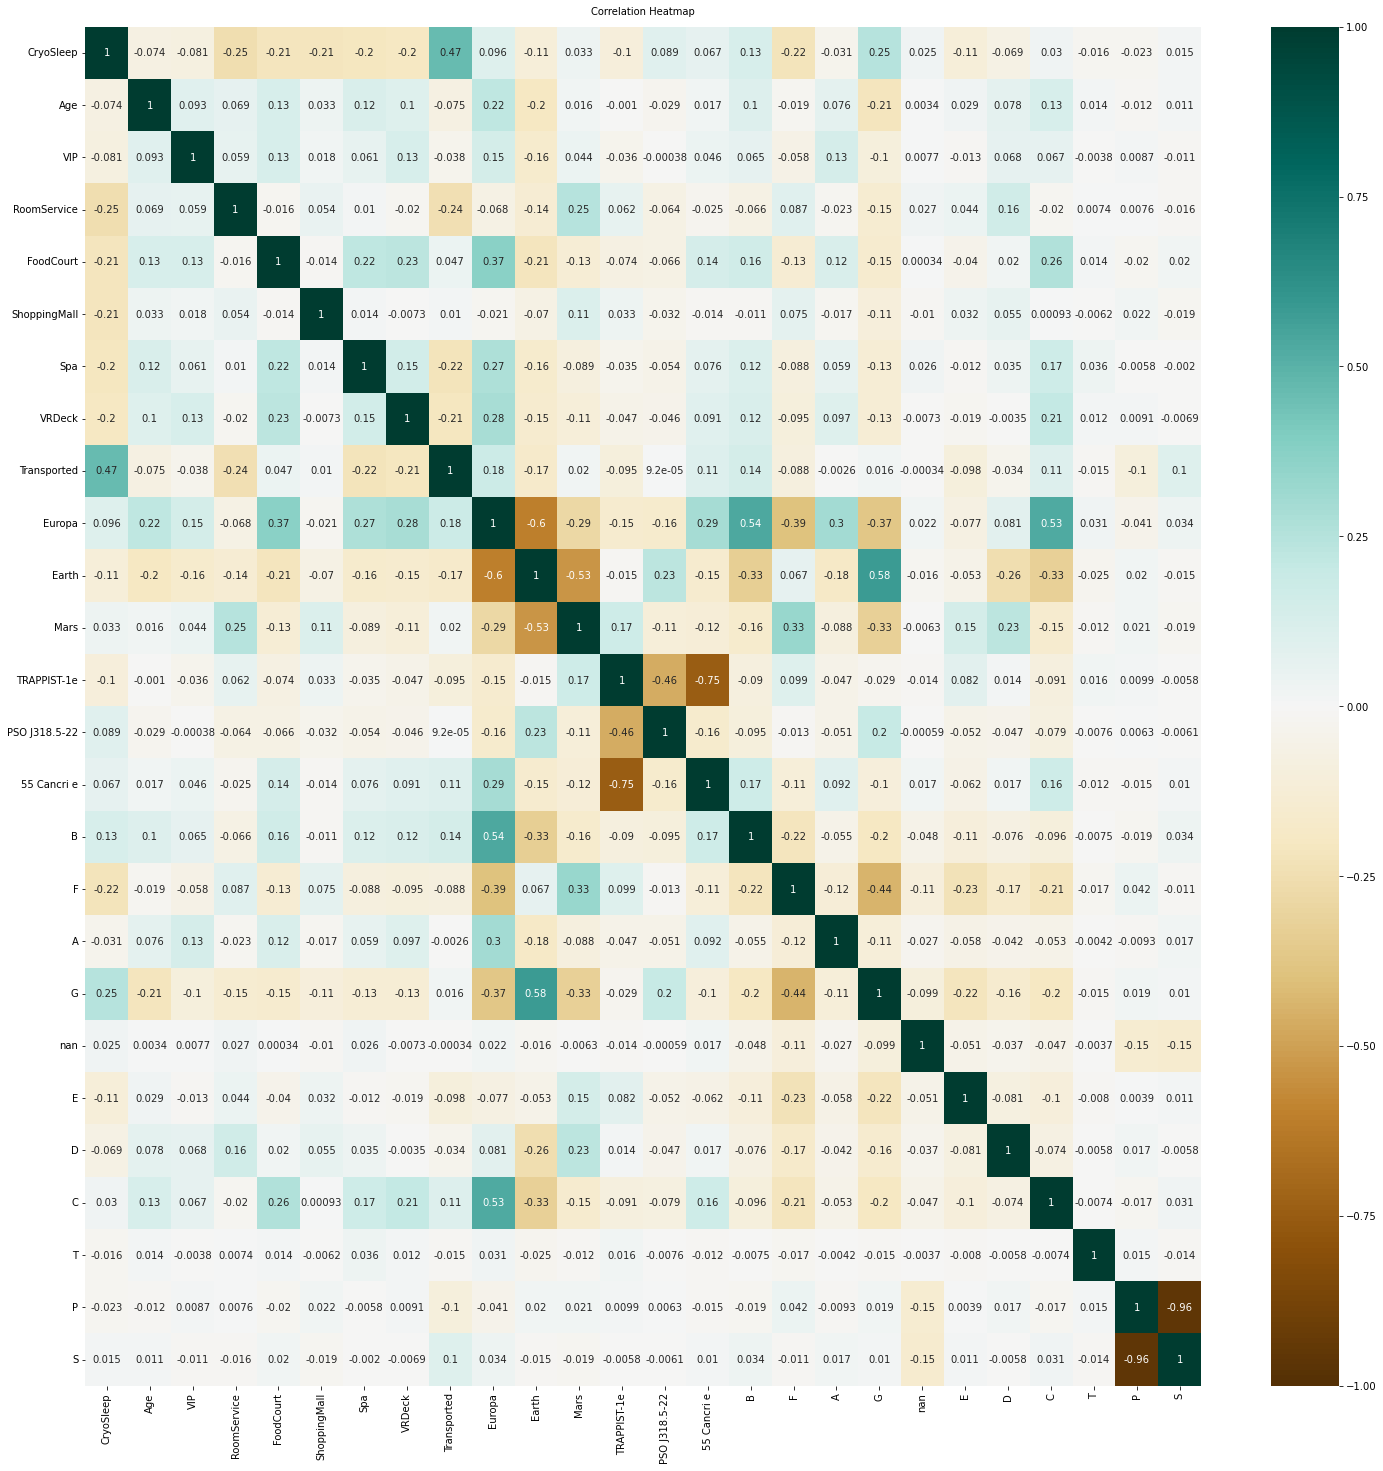

In [169]:
plt.figure(figsize=(25, 25))
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.show()

### Replace the Null Values

In [170]:
for col in train.columns:
    train[col].fillna(train[col].mean(), inplace=True)


In [171]:
print((train.isna().sum().sort_values(ascending = False)))

CryoSleep        0
Age              0
P                0
T                0
C                0
D                0
E                0
nan              0
G                0
A                0
F                0
B                0
55 Cancri e      0
PSO J318.5-22    0
TRAPPIST-1e      0
Mars             0
Earth            0
Europa           0
Transported      0
VRDeck           0
Spa              0
ShoppingMall     0
FoodCourt        0
RoomService      0
VIP              0
S                0
dtype: int64


In [172]:
print("Percentage of transported passengers:", train["Transported"].sum() / train["Transported"].count() * 100)

Percentage of transported passengers: 50.362360519958585


In [173]:
X = train.copy()
y = X["Transported"]
X.drop(["Transported"], axis = 1, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


In [174]:
X.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Europa,Earth,...,F,A,G,nan,E,D,C,T,P,S
0,0.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,0,1,...,1,0,0,0,0,0,0,0,0,1
2,0.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,1,0,...,0,1,0,0,0,0,0,0,0,1
3,0.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,1,0,...,0,1,0,0,0,0,0,0,0,1
4,0.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,0,1,...,1,0,0,0,0,0,0,0,0,1


# 3 Models

## Logisitic Regression

In [175]:
model_lr = LogisticRegression(random_state=0, fit_intercept=False, intercept_scaling=False, multi_class='ovr').fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.05%


## XGB

The best max_depth is: 4
Accuracy: 79.75%


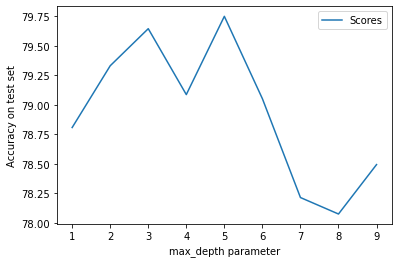

In [176]:
scores = []
for i in range(1, 10):
    model_xgb = XGBRegressor(max_depth=i, random_state=0).fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions) * 100
    scores.append(accuracy)


df = pd.DataFrame({'Scores' : scores})
df.index += 1
plt = df.plot()
plt.set_xlabel("max_depth parameter")
plt.set_ylabel("Accuracy on test set")

accuracy = max(scores)
best_depth = scores.index(accuracy)
print("The best max_depth is:", best_depth)
print("Accuracy: %.2f%%" % accuracy )

## Random Forest

The best max_depth is: 15
Accuracy: 80.41%


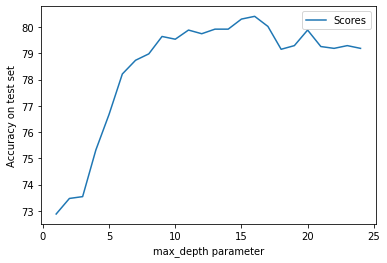

In [177]:
scores = []
for i in range(1, 25):
    model_rf = RandomForestClassifier(max_depth=i, random_state=0).fit(X_train, y_train)
    y_pred = model_rf.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions) * 100
    scores.append(accuracy)
    
df = pd.DataFrame({'Scores' : scores})
df.index += 1
plt = df.plot()
plt.set_xlabel("max_depth parameter")
plt.set_ylabel("Accuracy on test set")

accuracy = max(scores)
best_depth = scores.index(accuracy)
print("The best max_depth is:", best_depth)
print("Accuracy: %.2f%%" % accuracy )

### Random Forest model was the most accurate so we will make our predictions with it

In [178]:
# Clean up the test set
test = pd.read_csv("test.csv")



In [179]:
def port(row):
    cabin = str(row["Cabin"]).split('/')
    return cabin[0]
test["Port"] = test.apply(lambda row: port(row), axis = 1)

def side(row):
    cabin = str(row["Cabin"]).split('/')
    if len(cabin) == 3:
        return cabin[2]
test["Side"] = test.apply(lambda row: side(row), axis = 1)

In [180]:
test.drop(["PassengerId"], axis = 1, inplace = True)
test.drop(["Name"], axis = 1, inplace = True)
test.drop(["Cabin"], axis = 1, inplace = True)

In [181]:
test.replace({False: 0, True: 1}, inplace=True)


In [182]:
scaler = MinMaxScaler()
test_norm = pd.DataFrame(scaler.fit_transform(test[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]), columns=[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] )
test.loc[:, ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = test_norm[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]

In [183]:
planets = test["HomePlanet"].unique().tolist() 
destinations = test["Destination"].unique().tolist()
ports = test["Port"].unique().tolist()
sides =  test["Side"].unique().tolist()

def match(row, word, col):
    return int(str(row[col]) == str(word))
for cat in planets:
    test[cat] = test.apply(lambda row: match(row, cat, "HomePlanet"), axis = 1)
test.drop(["HomePlanet"], axis = 1, inplace = True)
for cat in destinations:
    test[cat] = test.apply(lambda row: match(row, cat, "Destination"), axis = 1)
test.drop(["Destination"], axis = 1, inplace = True)
for cat in ports:
    test[cat] = test.apply(lambda row: match(row, cat, "Port"), axis = 1)
test.drop(["Port"], axis = 1, inplace = True)
for cat in sides:
    test[cat] = test.apply(lambda row: match(row, cat, "Side"), axis = 1)
test.drop(["Side"], axis = 1, inplace = True)
test.drop([None], axis = 1, inplace = True)


In [184]:
test = test.loc[:, test.columns.notna()]

In [185]:
for col in test.columns:
    test[col].fillna(test[col].mean(), inplace=True)


In [186]:
print((test.isna().sum().sort_values(ascending = False)))


CryoSleep        0
PSO J318.5-22    0
S                0
T                0
A                0
nan              0
E                0
D                0
B                0
C                0
F                0
G                0
55 Cancri e      0
Age              0
TRAPPIST-1e      0
Mars             0
Europa           0
Earth            0
VRDeck           0
Spa              0
ShoppingMall     0
FoodCourt        0
RoomService      0
VIP              0
P                0
dtype: int64


In [187]:
# Train using the full training set with best max_depth
model_rf = RandomForestClassifier(max_depth=14).fit(X, y)
y_pred = model_rf.predict(test)
sub = pd.read_csv("sample_submission.csv")
sub["Transported"] = y_pred
sub.replace({0: False, 1: True}, inplace=True)
sub.to_csv("submission.csv", index=False)


In [188]:
sub.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
